# Portfolio Analysis and Error Detection
This notebook demonstrates the analysis of the portfolio data to detect errors using the `ARR_Application` library.

In [1]:
import sys
import os
import pandas as pd
import matplotlib.pyplot as plt

# Add project root to path
sys.path.append(os.path.abspath('..'))

from src.data_loader import DataLoader
from src.validators.price import PriceValidator

%matplotlib inline

## 1. Load Data
We load the portfolio data from the CSV file.

In [2]:
data_path = '../data/Test.csv'
loader = DataLoader(data_path)
positions, trades = loader.load_data()

print(f"Loaded {len(positions)} positions and {len(trades)} trades.")

Loaded 7721 positions and 468 trades.


## 2. Price Validation
We check for inconsistent price movements (jumps > 20%).

In [3]:
validator = PriceValidator(positions, trades)
errors = validator.validate()

print(f"Found {len(errors)} price errors.")

# Convert errors to DataFrame for display
if errors:
    error_df = pd.DataFrame([vars(e) for e in errors])
    display(error_df)
else:
    print("No price errors found.")

Found 3 price errors.


,date,ticker,error_type,description,severity
0,2022-12-07,CVNA,Price Spike,"Price spike detected: 3.83 (Prev: 6.71, Next: ...",High
1,2022-09-06,HSBK,Price Spike,"Price spike detected: 9.65 (Prev: 10.76, Next:...",Medium
2,2022-11-03,MBTN,Price Spike,"Price spike detected: 0.46 (Prev: 0.4, Next: 0...",Medium


## 3. Visualization
Let's visualize the price history of the tickers with errors to see the jumps.

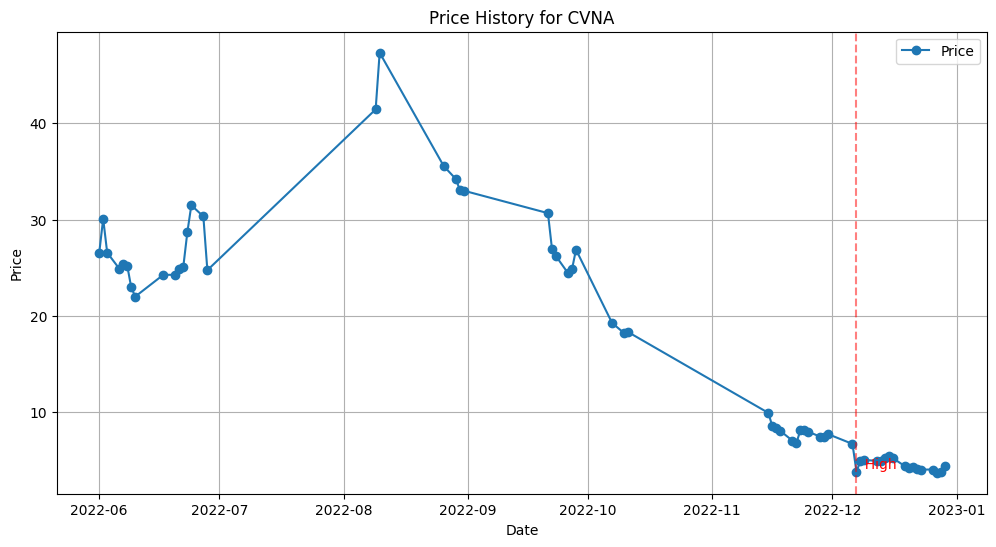

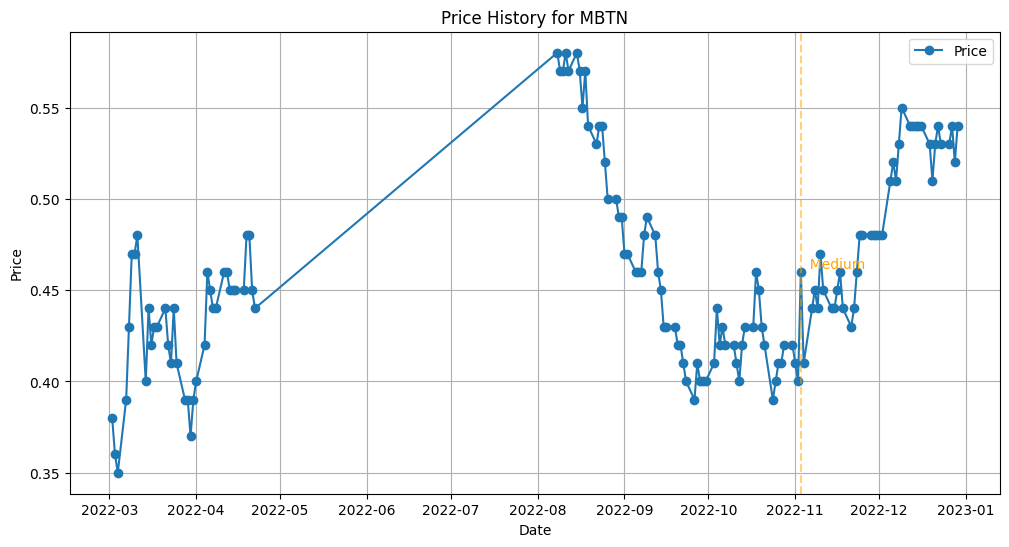

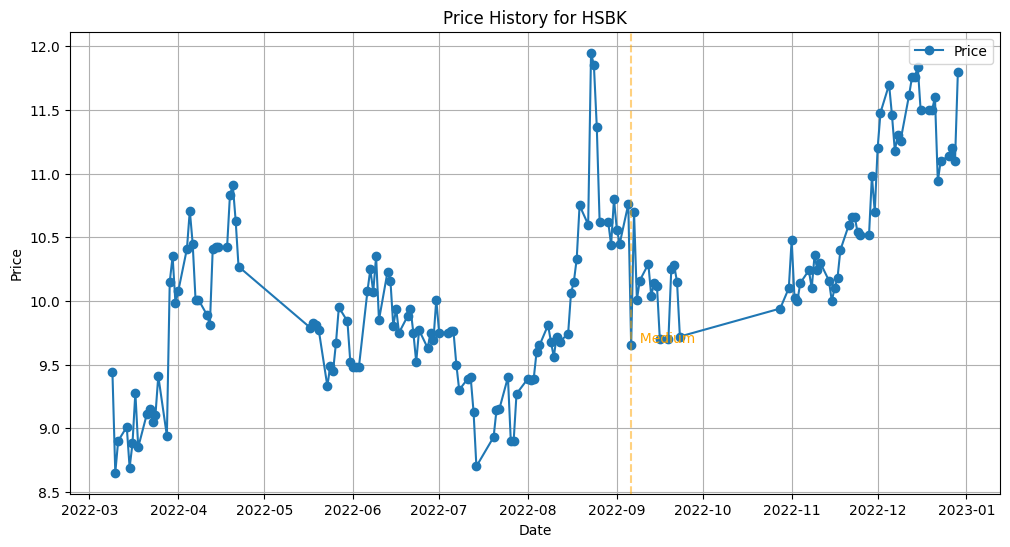

In [4]:
if errors:
    # Get unique tickers with errors
    error_tickers = set(e.ticker for e in errors)

    for ticker in error_tickers:
        ticker_data = positions[positions['P_Ticker'] == ticker].sort_values('Date')

        plt.figure(figsize=(12, 6))
        plt.plot(ticker_data['Date'], ticker_data['Price'], marker='o', label='Price')

        # Highlight error points
        ticker_errors = [e for e in errors if e.ticker == ticker]
        for err in ticker_errors:
            # Determine color based on severity
            severity = getattr(err, 'severity', 'High')
            color_map = {'High': 'red', 'Medium': 'orange', 'Low': 'green'}
            color = color_map.get(severity, 'red')

            plt.axvline(x=err.date, color=color, linestyle='--', alpha=0.5)  # type: ignore
            plt.text(
                err.date,  # type: ignore
                ticker_data[ticker_data["Date"] == err.date]["Price"].values[0],
                f"  {severity}",
                color=color,
                verticalalignment="bottom",
            )

        plt.title(f"Price History for {ticker}")
        plt.xlabel("Date")
        plt.ylabel("Price")
        plt.grid(True)
        plt.legend()
        plt.show()

## 4. Clean Data Visualization
Here we visualize a ticker with no detected errors and a dense history, to show what a "clean" time series looks like.

Visualizing clean ticker: 0486.HK


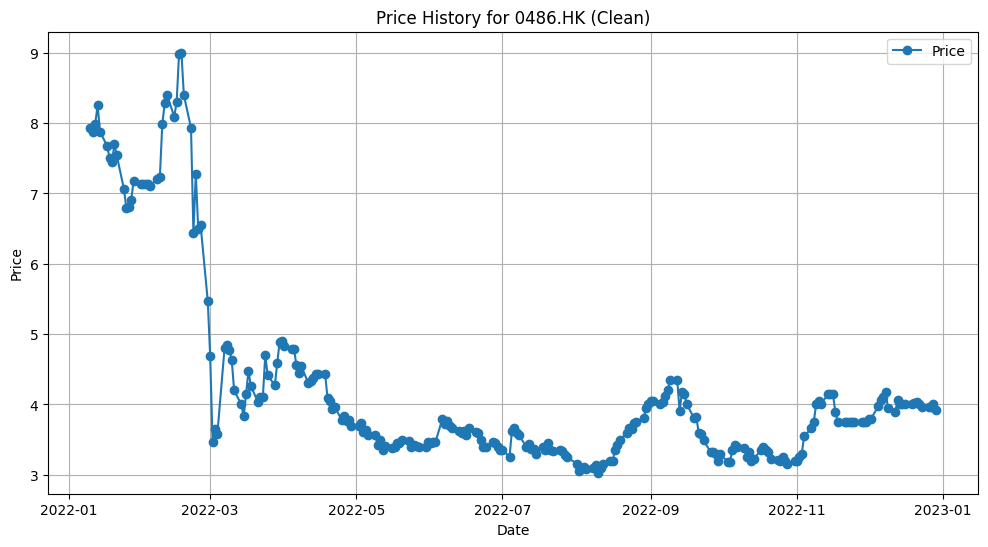

In [5]:
# Identify tickers with errors
error_tickers = set(e.ticker for e in errors) if errors else set()

# Find tickers without errors
clean_tickers = [t for t in positions['P_Ticker'].unique() if t not in error_tickers]

if clean_tickers:
    # Find the clean ticker with the most data points
    best_clean_ticker = max(clean_tickers, key=lambda t: len(positions[positions['P_Ticker'] == t]))
    
    print(f"Visualizing clean ticker: {best_clean_ticker}")
    
    ticker_data = positions[positions['P_Ticker'] == best_clean_ticker].sort_values('Date')
    
    plt.figure(figsize=(12, 6))
    plt.plot(ticker_data['Date'], ticker_data['Price'], marker='o', label='Price')
    
    plt.title(f"Price History for {best_clean_ticker} (Clean)")
    plt.xlabel("Date")
    plt.ylabel("Price")
    plt.grid(True)
    plt.legend()
    plt.show()
else:
    print("No clean tickers found.")